In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
import scikitplot as skplt
from sklearn import metrics
from collections import OrderedDict
from sklearn.datasets import make_classification

Features selected so far
Transition Probabilities: ['T to G', 'G to A', 'T to T', 'T to C', 'G to T', 'A to C']
Length categories: 
Upto window4: ['ATCA', 'ATC', 'ATCT', 'TATC', 'GATC', 'TCAG', 'TGGT', 'CGT', 'GCGT', 'CAGA', 'TCA', 'TCAT']
Window5: ['AGATC', 'GGATC', 'GCGTT', 'GATCA', 'ACGTG', 'ATCAG', 'GATCT', 'ATCAT',
       'CGCGT', 'ATCTC', 'ATATC', 'GTGGT', 'TCAGA', 'TGGTT', 'GCGTA', 'CACGT',
       'TCATC', 'AGCGT', 'CGCTT', 'CGTGT']
ORF counts: ['orfc ml200']

In [3]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], pd.read_csv('../ppnnw6.csv').iloc[:,10:1024]], axis = 1)
df1 = df1.loc[df1['die'] == 'no']


In [4]:
df1.loc[df1['Gen'] == 'ssRNA(+)', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(+)i', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(-)', 'Gen'] = 1
df1.loc[df1['Gen'] == 'ssRNA(-)g', 'Gen'] = 1

In [5]:
data = df1.reset_index(drop = True)

In [8]:
def rf(data, split, nest, crt, cvf):
    #Splitting features and labels
    X = data.iloc[:, 2:].values.astype(float)
    y = data.iloc[:, 0].values.astype(float)
    
    # Splitting the dataset into the Training set and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split)
    
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Fitting Random Forest Classification to the Training set
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators = nest, criterion = crt)
    classifier.fit(X_train, y_train)
    
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    
    cv_mic = cross_val_score(classifier, X, y, cv=cvf, scoring='f1_micro')
    cv_mac = cross_val_score(classifier, X, y, cv=cvf, scoring='f1_macro')
    f1mic = f1_score(y_test, y_pred, average='micro')
    f1mac = f1_score(y_test, y_pred, average='macro')
    
    
    dunnowhat = metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

    #feature selection 1
    selector1 = SelectFromModel(RandomForestClassifier(n_estimators = 250))
    selector1.fit(X_train, y_train)
#     #feature selection 2
#     selector2 = RFECV(RandomForestClassifier(n_estimators = 150), step=1, cv=5)
#     selector2 = selector2.fit(X_train, y_train)
    
#     return (selector1.get_support()), (selector2.get_support())


    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 175

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

    return cv_mic, cv_mac, f1mic, f1mac, selector1

In [ ]:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

# Generate a binary classification dataset.

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [84]:
a,b = rf(df, 0.25, 150, 'entropy', 5)

In [85]:
df.iloc[:,2:].columns[~b]

Index([], dtype='object')

In [86]:
df.iloc[:,2:].columns[~a]

Index(['T to G', 'G to A', 'T to T', 'T to C', 'G to T', 'A to C', 'TATC',
       'TCAG', 'TGGT', 'CGT', 'GCGT', 'CAGA', 'TCAT', 'GGATC', 'GCGTT',
       'ACGTG', 'GATCT', 'CGCGT', 'ATCTC', 'GTGGT', 'TCAGA', 'TGGTT', 'GCGTA',
       'CACGT', 'TCATC', 'AGCGT', 'CGCTT', 'CGTGT'],
      dtype='object')

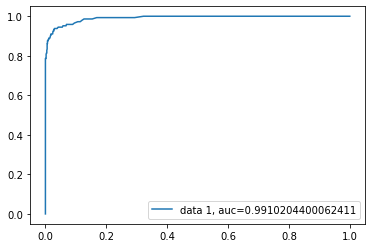

KeyboardInterrupt: 

In [7]:
cv_mic, cv_mac, f1mic, f1mac, sel1, sel2 = rf(data, 0.25, 250, 'entropy', 5)

print(cv_mic.mean(), cv_mic.std(), cv_mac.mean(), cv_mac.std(), f1mic, f1mac)

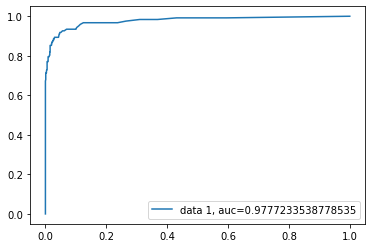

0.9705906525588835 0.006621413714141284 0.9217966560122681 0.012277141986960222 0.966958211856171 0.9154992850794141


In [46]:
cv_mic, cv_mac, f1mic, f1mac = rf(data, 0.25, 250, 'entropy', 5)

print(cv_mic.mean(), cv_mic.std(), cv_mac.mean(), cv_mac.std(), f1mic, f1mac)

In [92]:
cv_bin, cv_mac, f1bin, f1mac = rf(df, 0.25, 150, 'entropy', 5)

print(cv_bin.mean(), cv_bin.std(), cv_mac.mean(), cv_mac.std(), f1bin, f1mac)

0.9168011409857175 0.05429153763125063 0.9576400565161756 0.023630328422923095 1.0 1.0
